Object Detection Using YOLO

Set Up YOLOv5 Environment

In [1]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


c:\Users\USER\Documents\OPLearning\10_Academy\Week_7\notebooks\yolov5


c:\Users\USER\Documents\OPLearning\10_Academy\Week_7\myenv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import cv2
import os

image_folder = r"C:\Users\USER\Documents\OPLearning\10_Academy\Week_7\data\downloaded_images"


 Perform Object Detection and Save Results

In [3]:
import torch
import pandas as pd
import logging
import glob
import matplotlib.pyplot as plt
import hashlib
import shutil

os.makedirs('detection_results', exist_ok=True)
os.makedirs('../selected_examples', exist_ok=True)

In [4]:

logging.basicConfig(filename='detection.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

def compute_image_hash(image_path):
    with open(image_path, "rb") as image_file:
        buffer = image_file.read()
    hash_object = hashlib.md5(buffer)
    return hash_object.hexdigest()

In [5]:
unique_hashes = set()
duplicate_images = []
for filename in os.listdir(image_folder):
    image_path = os.path.join(image_folder, filename)
    image_hash = compute_image_hash(image_path)
    if image_hash in unique_hashes:
        duplicate_images.append(filename)
    else:
        unique_hashes.add(image_hash)

if duplicate_images:
    logging.warning(f"Found {len(duplicate_images)} duplicate images:")
    logging.warning(", ".join(duplicate_images))
else:
    logging.info("No duplicate images found.")

In [6]:
filtered_images = [img for img in os.listdir(image_folder) if img not in duplicate_images]
image_folder = image_folder
selected_images = filtered_images[:100]  

In [7]:
import torch

model = torch.hub.load("ultralytics/yolov5", "yolov5s", force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\USER/.cache\torch\hub\master.zip
YOLOv5  2024-10-15 Python-3.11.2 torch-2.4.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [8]:
%%capture
%xmode Minimal


for img_name in selected_images:
    try:
        img_path = os.path.join(image_folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            logging.warning(f"Warning: {img_name} could not be loaded.")
            continue

        results = model(img)

        shutil.copy2(img_path, '../selected_examples/')
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"{img_name}")
        plt.savefig(f'selected_examples/{img_name}.png', bbox_inches='tight')
        plt.close()

        results.save(save_dir='detection_results/')

        detections = results.pandas().xyxy[0]
        csv_path = f'detection_results/{img_name}_detections.csv'
        detections[['name', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']].to_csv(csv_path, index=False)

        logging.info(f"Successfully processed {img_name}")
    except Exception as e:
        logging.error(f"Error processing {img_name}: {str(e)}")

print("Detection completed.")


Saved 1 image to detection_results202
Saved 1 image to detection_results203
Saved 1 image to detection_results204
Saved 1 image to detection_results205
Saved 1 image to detection_results206
Saved 1 image to detection_results207
Saved 1 image to detection_results208
Saved 1 image to detection_results209
Saved 1 image to detection_results210
Saved 1 image to detection_results211
Saved 1 image to detection_results212
Saved 1 image to detection_results213
Saved 1 image to detection_results214
Saved 1 image to detection_results215
Saved 1 image to detection_results216
Saved 1 image to detection_results217
Saved 1 image to detection_results218
Saved 1 image to detection_results219
Saved 1 image to detection_results220
Saved 1 image to detection_results221
Saved 1 image to detection_results222
Saved 1 image to detection_results223
Saved 1 image to detection_results224
Saved 1 image to detection_results225
Saved 1 image to detection_results226
Saved 1 image to detection_results227
Saved 1 imag

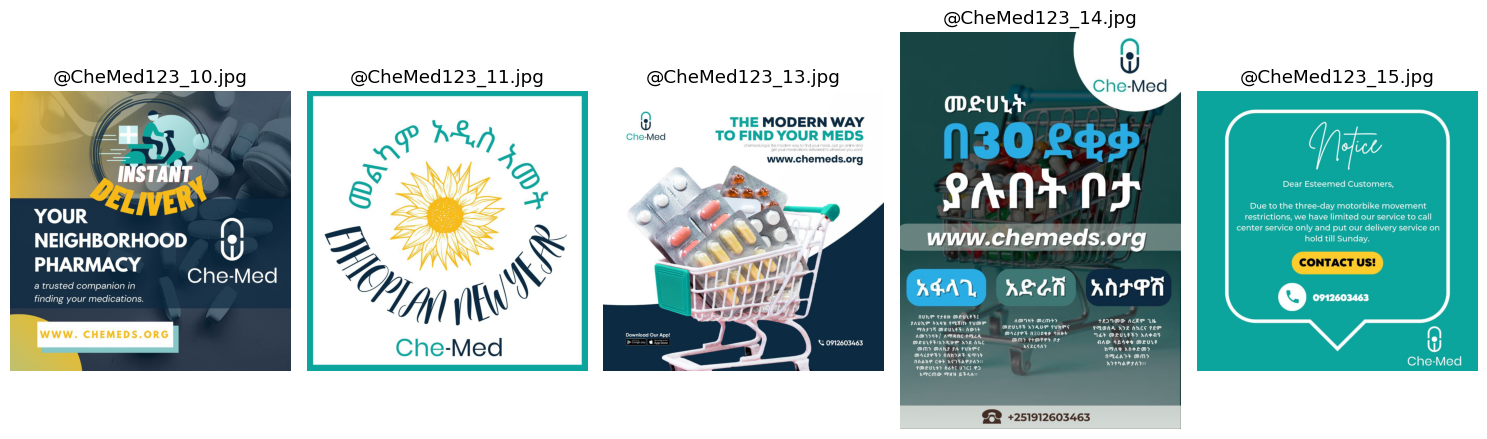

In [15]:
%matplotlib inline

plt.figure(figsize=(15, 15))
for i, img_name in enumerate(selected_images[:5]):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"{img_name}")
plt.tight_layout()
plt.show()

In [16]:
csv_files = glob.glob('detection_results/*.csv')
combined_data = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
print(combined_data.describe())

C:\Users\USER\AppData\Local\Temp\ipykernel_4448\4264263246.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)


       confidence         xmin         ymin         xmax         ymax
count  231.000000   231.000000   231.000000   231.000000   231.000000
mean     0.555788   466.301064   363.914132   690.608259   676.827726
std      0.218828   294.122041   216.552067   286.539041   222.433730
min      0.251771     0.000000     0.000000    55.163864    97.210968
25%      0.355400   213.076729   219.852371   471.741272   530.111969
50%      0.510287   489.223846   331.642975   686.277222   682.402588
75%      0.759331   692.873138   525.208984   880.811188   823.590363
max      0.942370  1178.683594  1115.261108  1280.000000  1280.000000


In [26]:
def calculate_map(detections):
    if isinstance(detections, dict):
        confidences = detections.get('confidence', [])
    elif isinstance(detections, list):
        confidences = [float(d.get('confidence', 0)) for d in detections]
    else:
        confidences = []
    
    return np.mean(confidences) if confidences else 0

class_performance = combined_data.groupby('name').apply(lambda x: calculate_map(x)).reset_index()
class_performance.columns = ['Class', 'mAP']

C:\Users\USER\AppData\Local\Temp\ipykernel_4448\1896199039.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_performance = combined_data.groupby('name').apply(lambda x: calculate_map(x)).reset_index()


In [28]:
import glob

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

input_dir = 'detection_results/'
output_file = 'merged_detections.csv'

def merge_csv_files(input_dir, output_file):
    csv_files = glob.glob(os.path.join(input_dir, '*.csv'))
    
    dfs = [pd.read_csv(file) for file in csv_files]
    
    merged_df = pd.concat(dfs, ignore_index=True)
    
    for file in csv_files:
        os.remove(file)
    
    merged_df.to_csv(output_file, index=False)
    
    logging.info(f"Merged detections saved to {output_file}")
    return merged_df

merged_detections = merge_csv_files(input_dir, output_file)

logging.info(f"Total rows in merged detections: {len(merged_detections)}")

sample_size = min(10, len(merged_detections))
print("\nSample of merged detections:")
print(merged_detections.head(sample_size))

total_objects = merged_detections['confidence'].sum()
average_confidence = merged_detections['confidence'].mean()
max_confidence = merged_detections['confidence'].max()
min_confidence = merged_detections['confidence'].min()

logging.info(f"\nStatistics:")
logging.info(f"Total detected objects: {total_objects:.2f}")
logging.info(f"Average confidence: {average_confidence:.2f}")
logging.info(f"Max confidence: {max_confidence:.2f}")
logging.info(f"Min confidence: {min_confidence:.2f}")

logging.info("Detection completed.")


C:\Users\USER\AppData\Local\Temp\ipykernel_4448\4292626802.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(dfs, ignore_index=True)



Sample of merged detections:
          name  confidence        xmin        ymin         xmax         ymax
0       toilet    0.630541  888.736938  182.224213  1079.087280   412.944855
1  sports ball    0.426693  739.565552  545.680359   808.522095   616.905579
2  sports ball    0.415903  318.585602  395.181885   382.618805   462.202637
3  sports ball    0.279390  149.630676  546.466370   220.806213   610.163635
4       bottle    0.654968  576.642822  380.432526   606.642822   461.364899
5       bottle    0.468414  504.802734  451.700378   543.136108   543.512024
6       bottle    0.366134  610.317322  525.526611   639.527283   605.154541
7       remote    0.343657  691.656799  903.706848   830.607239  1046.755127
8       bottle    0.326229  547.922668  394.158783   578.633240   454.397675
9       bottle    0.294806  397.996429  506.013031   441.424896   611.667175
